# Spectrum discretization and repetition period

This tutorial illustrates the discretisation of wave spectrum into a finite number of components.

In [1]:
from Snoopy import Spectral as sp
from Snoopy import TimeDomain as td
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from Snoopy.PyplotTools import set_major_format

**Seastate used for the illustration :**

In [2]:
ss = sp.SeaState.Jonswap(1, 10 , 1.0 , np.pi )
wmin, wmax, dw = 0.2, 1.8 , 0.01

## Repetition period

If spectrum is discretized with even frequency, a repetition period appears at $2\pi/d\omega$

In [3]:
wif = sp.Wif( ss , w = np.arange(0.2 , 1.8 , dw) ) 
print (wif.get_trepeat())

628.3185307179581


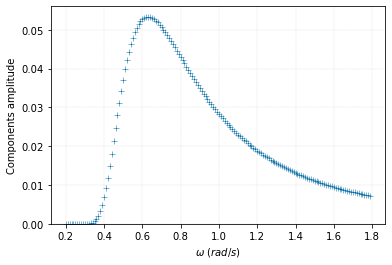

In [4]:
wif.plot();

In [5]:
td.ReconstructionWifLocal(wif).evalSe(np.arange(0,2400 , 0.5)).plot();

## Random frequency offset

To avoid this repetition period, and to have longer run without increasing dramatically the number of component, random offset of the frequencies can be added. In Snoopy, this is done using the following **Wif** constructor :

In [6]:
wif = sp.Wif( ss , nbSeed = 200 ) 
print (wif.get_trepeat())

inf


In [7]:
wif.plot();

Because of the random bandwidth associated to each components, the amplitudes of the wif file looks noisy. Also note that the algorithm implemented in Snoopy put slightly more component in the energetic part of the wave spectrum.

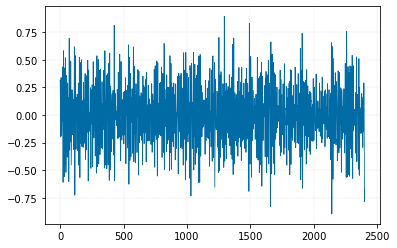

In [8]:
td.ReconstructionWifLocal(wif).evalSe(np.arange(0,2400 , 0.5)).plot();

Then, no repetition period can be observed.

## Illustrate equilalence of convergence rate

To illustrate the validity of the approach using random offset to perform one single simulation instead of several smaller ones. The rate of convergence of the mean maximum on a given duration is compared.

The reference calculation is using 5000 independant calculation of 100s

In [9]:
n = 5000
t_single = 100
time_single = np.arange(0 , t_single , 0.5)

5000 independant discretisation with random phases are performed, followed by 5000 independant time reconstructions of 100s

In [10]:
wif_r = [ sp.Wif( ss , w = np.arange(0.2 , 1.8 , dw) ) for i in range(n) ]
tsList = [td.ReconstructionWifLocal(wif_).evalSe( time_single ) for wif_ in wif_r ]

The mean maximum over 100s is then obtain by :

In [11]:
maxList = np.array([np.max(ts_) for ts_ in tsList ])
maxmoy_ref = np.mean( maxList )

The rate of convergence can be obtained by calculating the standard deviation of the mean maximum, depending on the number of simulations performed.

In [12]:
n_range = np.array([2, 4 , 10 , 20, 50, 100 , 200, 500,])
cov = np.zeros ((len(n_range)) )
for i, r in enumerate(n_range) : 
    cov[i] = np.std( np.mean( maxList.reshape( n // r , r) , axis = 1 )) / maxmoy_ref

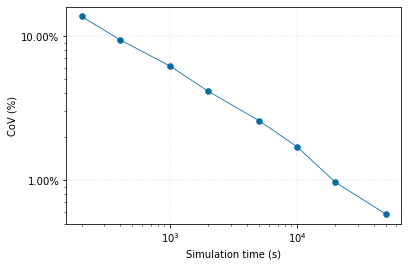

In [13]:
fig , ax = plt.subplots()
ax.plot( n_range*t_single , cov  , "o-")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("CoV (%)")
ax.set_xlabel("Simulation time (s)")
set_major_format(ax, format = ".2%", axis = "y")

**Now, same calculation is performed, using a single, large, calculation**

In [14]:
wif = sp.Wif( ss , nbSeed = int(0.8*(wmax-wmin)/dw))

In [15]:
allTime = np.arange(0. , t_single * n , 0.5)

In [16]:
ts = td.ReconstructionWifLocal(wif).evalSe( allTime ) 

In [17]:
maxList2 = np.array([ np.max( ts.loc[i*t_single:(i+1)*t_single] ) for i in range(n) ])
maxmoy_long = np.mean( maxList2 )

In [18]:
print (f"Difference between both approach : {maxmoy_long / maxmoy_ref -1:.2%} ==> compatible with sampling error"  )

Difference between both approach : 0.61% ==> compatible with sampling error


**Convergence rate can also be compared :**

In [19]:
cov2 = np.zeros ((len(n_range)) )
for i, r in enumerate(n_range) : 
    cov2[i] = np.std( np.mean( maxList2.reshape( n // r , r) , axis = 1 )) / maxmoy_ref

In [20]:
fig , ax = plt.subplots()
ax.plot( n_range*t_single , cov  , "o-", label = f"{n:} runs of {t_single:}s")
ax.plot( n_range*t_single , cov2  , "x--", label = f"1 run of {t_single*n:}s")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel("CoV (%)")
ax.set_xlabel("Simulation time")
ax.legend()
set_major_format(ax , format = ".2%" , axis = "y")

==> Convergence rates of both approach are the same